<a href="https://colab.research.google.com/github/noralizaaa/Klasifikasi-Burnout-pada-Mahasiswa-dan-Pekerja/blob/main/Pre_trained_(DistilBERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# Impor Library yang Dibutuhkan
# ==========================================
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import pandas as pd
import torch
import os
from google.colab import drive
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from IPython.display import display
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.exceptions import ConvergenceWarning
import warnings

# Download stopwords (dibutuhkan untuk fungsi clean_text)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Abaikan warning konvergensi agar output lebih bersih
warnings.filterwarnings("ignore", category=ConvergenceWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# ==========================================
# 1. Load Dataset
# ==========================================
file_path = "/content/Burnout_3_Class_Filtered (1).csv"
df = pd.read_csv(file_path)

print(df.info())
print("\nDistribusi label:\n", df['label'].value_counts())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25204 entries, 0 to 25203
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              25204 non-null  object 
 1   label             25204 non-null  object 
 2   label_text        25204 non-null  object 
 3   similarity_score  25204 non-null  float64
dtypes: float64(1), object(3)
memory usage: 787.8+ KB
None

Distribusi label:
 label
worker_burnout     16648
college_burnout     6556
no_burnout          2000
Name: count, dtype: int64


,text,label,label_text,similarity_score
0,i just dont understand why i feel so lost abou...,college_burnout,disappointment,0.404118
1,i feel soo ungrateful today,no_burnout,disappointment,0.492512
2,i do what i do and how i seem to always be pow...,worker_burnout,disappointment,0.459672
3,i need to feel valuable,worker_burnout,joy,0.497510
4,i feel super weak and i havent made it through...,college_burnout,joy,0.405756


In [ ]:
# ==========================================
# 7. Preprocessing Text (Versi Bersih/Silent)
# ==========================================
def clean_text(df_text):
    text_series = df_text.copy()

    # 1. Lowercase
    text_series = text_series.str.lower()

    # 2. Hapus URL
    text_series = text_series.str.replace(r"http\S+|www\S+|https\S+", "", regex=True)

    # 3. Hapus Emoji / Emoticon
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               "]+", flags=re.UNICODE)
    text_series = text_series.apply(lambda x: emoji_pattern.sub(r'', x))

    # 4. Hapus angka & karakter spesial (hanya sisakan a-z dan spasi)
    text_series = text_series.str.replace(r"[^a-z\s]", "", regex=True)

    # 5. Hapus spasi berlebih
    text_series = text_series.str.replace(r"\s+", " ", regex=True).str.strip()

    # 6. Hapus Stopwords
    text_series = text_series.apply(lambda x: " ".join([w for w in x.split() if w not in stop_words]))

    return text_series

# Terapkan ke seluruh dataset
print("\n🧹 Memulai preprocessing pada data final...")
df_final = df.copy() # Initialize df_final with a copy of df
df_final['clean_text'] = clean_text(df_final['text'])

print("✅ Preprocessing selesai.")
display(df_final[['text', 'clean_text', 'label']].head())


🧹 Memulai preprocessing pada data final...
✅ Preprocessing selesai.


,text,clean_text,label
0,i just dont understand why i feel so lost abou...,dont understand feel lost though,college_burnout
1,i feel soo ungrateful today,feel soo ungrateful today,no_burnout
2,i do what i do and how i seem to always be pow...,seem always powering along feel inadequate,worker_burnout
3,i need to feel valuable,need feel valuable,worker_burnout
4,i feel super weak and i havent made it through...,feel super weak havent made whole class two week,college_burnout


In [ ]:
# ==========================================
# 8. Encode Label & Oversampling
# ==========================================
print("\n🔄 Melakukan Label Encoding dan Oversampling...")
X = df_final["clean_text"].fillna('') # Ganti NaN (jika ada) dengan string kosong
y = df_final["label"]

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Label Asli: {le.classes_}")
print(f"Label Encoded: {np.unique(y_encoded)}")

# Oversampling untuk kelas minoritas
ros = RandomOverSampler(random_state=42)
X_reshaped = X.values.reshape(-1, 1)
X_resampled, y_resampled = ros.fit_resample(X_reshaped, y_encoded)
X_resampled = X_resampled.ravel()

print("\nDistribusi Kelas Setelah Oversampling:")
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(le.inverse_transform(unique), counts)))



🔄 Melakukan Label Encoding dan Oversampling...
Label Asli: ['college_burnout' 'no_burnout' 'worker_burnout']
Label Encoded: [0 1 2]

Distribusi Kelas Setelah Oversampling:
{'college_burnout': np.int64(16648), 'no_burnout': np.int64(16648), 'worker_burnout': np.int64(16648)}


In [ ]:
# ==========================================
# 9. Split Train-Test
# ==========================================
print("\n🔪 Membagi data menjadi Train dan Test...")
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)
print(f"Ukuran X_train: {len(X_train)}")
print(f"Ukuran X_test: {len(X_test)}")


🔪 Membagi data menjadi Train dan Test...
Ukuran X_train: 39955
Ukuran X_test: 9989


In [ ]:
# ==========================================
# 10. Feature Extraction (4 METODE TERPISAH)
# ==========================================
# (Ini mengasumsikan X_train, X_test, y_train, y_test sudah ada dari split)

# --- Metode 1: TF-IDF (Unigrams) ---
print("\n1️⃣ Menerapkan Metode 1: TF-IDF (Unigrams)...")
tfidf_vec_uni = TfidfVectorizer(
    ngram_range=(1, 1),      # Hanya unigrams
    max_features=10000,
    max_df=0.95,
    min_df=5
)
X_train_tfidf_uni = tfidf_vec_uni.fit_transform(X_train)
X_test_tfidf_uni = tfidf_vec_uni.transform(X_test)
print(f"Bentuk X_train_tfidf_uni: {X_train_tfidf_uni.shape}")

# --- Metode 2: TF-IDF (dengan N-grams) ---
print("\n2️⃣ Menerapkan Metode 2: TF-IDF (N-grams)...")
tfidf_vec_ng = TfidfVectorizer(
    ngram_range=(1, 3),      # Unigrams, Bigrams, dan Trigrams
    max_features=15000,      # N-grams butuh lebih banyak fitur
    max_df=0.95,
    min_df=5
)
X_train_tfidf_ng = tfidf_vec_ng.fit_transform(X_train)
X_test_tfidf_ng = tfidf_vec_ng.transform(X_test)
print(f"Bentuk X_train_tfidf_ng: {X_train_tfidf_ng.shape}")

# --- Metode 3: LDA (Latent Dirichlet Allocation) ---
print("\n3️⃣ Menerapkan Metode 3: LDA...")
print("Membuat CountVectorizer (unigrams) untuk input LDA...")
count_vec_lda = CountVectorizer(
    ngram_range=(1, 1),
    max_features=5000,
    max_df=0.90,
    min_df=10,
    stop_words='english' # Gunakan stopwords bawaan sklearn untuk LDA
)
X_train_counts = count_vec_lda.fit_transform(X_train)
X_test_counts = count_vec_lda.transform(X_test)

n_topics = 15 # Anda bisa sesuaikan jumlah topik
print(f"Fitting LDA dengan {n_topics} topik...")
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    n_jobs=-1,
    learning_method='batch'
)
X_train_lda = lda.fit_transform(X_train_counts)
X_test_lda = lda.transform(X_test_counts)
print(f"Bentuk X_train_lda (fitur): {X_train_lda.shape}")

# --- Metode 4: Bag-of-Words (BoW) (Unigrams) ---
print("\n4️⃣ Menerapkan Metode 4: Bag-of-Words (BoW)...")
bow_vec_uni = CountVectorizer(
    ngram_range=(1, 1),
    max_features=10000,
    max_df=0.95,
    min_df=5
)
X_train_bow_uni = bow_vec_uni.fit_transform(X_train)
X_test_bow_uni = bow_vec_uni.transform(X_test)
print(f"Bentuk X_train_bow_uni: {X_train_bow_uni.shape}")

print("\n\n✅✅✅ Proses Feature Extraction Selesai ✅✅✅")


1️⃣ Menerapkan Metode 1: TF-IDF (Unigrams)...
Bentuk X_train_tfidf_uni: (39955, 5023)

2️⃣ Menerapkan Metode 2: TF-IDF (N-grams)...
Bentuk X_train_tfidf_ng: (39955, 15000)

3️⃣ Menerapkan Metode 3: LDA...
Membuat CountVectorizer (unigrams) untuk input LDA...
Fitting LDA dengan 15 topik...
Bentuk X_train_lda (fitur): (39955, 15)

4️⃣ Menerapkan Metode 4: Bag-of-Words (BoW)...
Bentuk X_train_bow_uni: (39955, 5023)


✅✅✅ Proses Feature Extraction Selesai ✅✅✅




🤗 MEMULAI TRAINING PRE-TRAINED MODEL (DISTILBERT)
Device: cuda
📥 Mengunduh Tokenizer: distilbert-base-uncased...
⚙️ Encoding data (Max Len: 128)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📥 Mengunduh Model: distilbert-base-uncased...

🚀 Mulai Fine-Tuning...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.216900,0.199192,0.929823
2,0.127500,0.151063,0.951246
3,0.064100,0.138537,0.961958



📊 Evaluasi Model...


🎉 Akurasi Test DistilBERT: 96.20%

Laporan Klasifikasi DistilBERT:
                 precision    recall  f1-score   support

college_burnout       0.94      0.98      0.96      3329
     no_burnout       0.97      1.00      0.99      3330
 worker_burnout       0.98      0.91      0.94      3330

       accuracy                           0.96      9989
      macro avg       0.96      0.96      0.96      9989
   weighted avg       0.96      0.96      0.96      9989



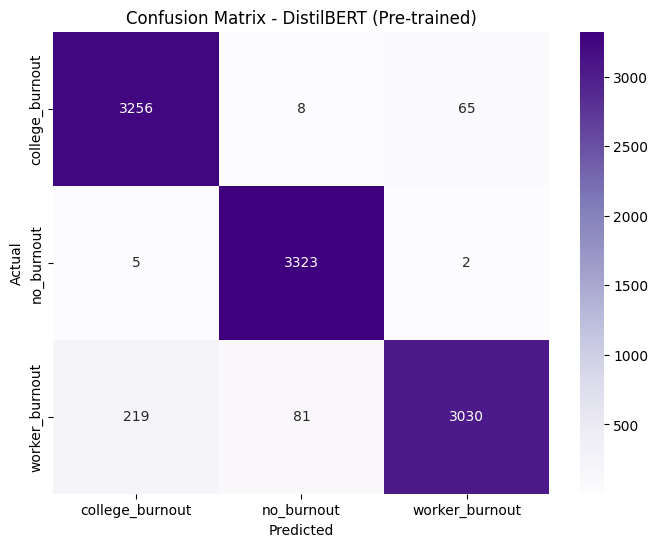



🏆 KESIMPULAN AKHIR KOMPARASI MODEL
1. Classic ML (Best)         : Cek hasil di atas
2. Deep Learning (BiLSTM)    : Cek hasil di atas
3. Pre-trained (DistilBERT)  : 96.20%


In [ ]:
# ==========================================
# 16. Metode 6: Fine-Tuning Pre-trained Transformer (DistilBERT - PyTorch)
# ==========================================
print("\n\n==============================================")
print("🤗 MEMULAI TRAINING PRE-TRAINED MODEL (DISTILBERT)")
print("==============================================")

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cek GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# -------------------------------------------------
# Load Tokenizer & Encoding
# -------------------------------------------------
model_name = 'distilbert-base-uncased'
print(f"📥 Mengunduh Tokenizer: {model_name}...")
tokenizer_bert = DistilBertTokenizer.from_pretrained(model_name)

def bert_encode(data, maximum_length):
    encoded_data = tokenizer_bert.batch_encode_plus(
        list(data),
        add_special_tokens=True,
        max_length=maximum_length,
        padding='max_length',
        truncation=True,
        return_tensors='np'
    )
    return encoded_data['input_ids'], encoded_data['attention_mask']

MAX_LEN_BERT = 128
print(f"⚙️ Encoding data (Max Len: {MAX_LEN_BERT})...")
train_input_ids, train_attention_masks = bert_encode(X_train, MAX_LEN_BERT)
test_input_ids, test_attention_masks = bert_encode(X_test, MAX_LEN_BERT)

# -------------------------------------------------
# PyTorch Dataset Class
# -------------------------------------------------
class BurnoutDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = BurnoutDataset(train_input_ids, train_attention_masks, y_train)
test_dataset = BurnoutDataset(test_input_ids, test_attention_masks, y_test)

# -------------------------------------------------
# Load Model
# -------------------------------------------------
print(f"📥 Mengunduh Model: {model_name}...")
model_bert = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(le.classes_)
)
model_bert.to(device)

# -------------------------------------------------
# Training Setup (DIPERBAIKI)
# -------------------------------------------------
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    eval_strategy="epoch",  # DIPERBAIKI: evaluation_strategy -> eval_strategy
    logging_steps=100,
    report_to="none",
    use_cpu=False  # Gunakan GPU jika tersedia
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {'accuracy': accuracy_score(labels, preds)}

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# -------------------------------------------------
# Training
# -------------------------------------------------
print("\n🚀 Mulai Fine-Tuning...")
trainer.train()

# -------------------------------------------------
# Evaluasi
# -------------------------------------------------
print("\n📊 Evaluasi Model...")
eval_result = trainer.evaluate()
acc_bert = eval_result['eval_accuracy']
print(f"🎉 Akurasi Test DistilBERT: {acc_bert*100:.2f}%")

# Prediksi
predictions = trainer.predict(test_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=1)

print("\nLaporan Klasifikasi DistilBERT:")
print(classification_report(
    y_test,
    y_pred_bert,
    target_names=le.classes_,
    zero_division=0
))

# Confusion Matrix
cm_bert = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - DistilBERT (Pre-trained)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==========================================
# 17. Komparasi Akhir Semua Model
# ==========================================
print("\n\n🏆 KESIMPULAN AKHIR KOMPARASI MODEL")
print(f"1. Classic ML (Best)         : Cek hasil di atas")
print(f"2. Deep Learning (BiLSTM)    : Cek hasil di atas")
print(f"3. Pre-trained (DistilBERT)  : {acc_bert*100:.2f}%")
